/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


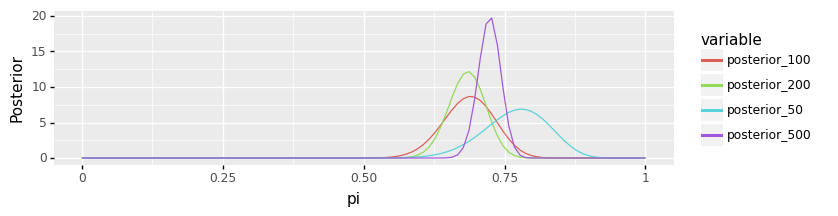

<ggplot: (321057163)>

In [1]:
import numpy as np
from scipy.special import beta
from scipy import integrate
from plotnine import ggplot, geom_line, geom_point, aes, xlab, ylab, ggtitle, geom_density
import plotnine.options as ggplot_options
import pandas as pd

ggplot_options.figure_size = (8, 2)

x_50  = np.random.choice([0, 1], replace = True, size = 50, p=[0.3, 0.7])
x_100 = np.random.choice([0, 1], replace = True, size = 100, p=[0.3, 0.7])
x_200 = np.random.choice([0, 1], replace = True, size = 200, p=[0.3, 0.7])
x_500 = np.random.choice([0, 1], replace = True, size = 500, p=[0.3, 0.7])

def posterior(pi, x):
    n = (x == 1).sum()
    m = (x == 0).sum()
    return (pi**n * (1-pi)**m) / beta(n + 1, m + 1)

pi = np.linspace(0, 1, 100)
posteriors = posterior(pi, x_50)

# its a probability density function so it should integrate to 1
# integral = integrate.quad(lambda pi: posterior(pi, x), 0, 1)[0]
# print(f"∫p(π|x)dπ = {round(integral)}")

(pd.DataFrame({
    'pi': pi,
    'posterior_50': posterior(pi, x_50),
    'posterior_100': posterior(pi, x_100),
    'posterior_200': posterior(pi, x_200),
    'posterior_500': posterior(pi, x_500)
})
 .melt(id_vars='pi')
 .pipe(ggplot) + aes(x='pi', y='value', color='variable') + geom_line() + ylab("Posterior")
)


In [2]:
from scipy.optimize import fmin

# the bisect is linearly fast method
def bisect(left, right, n, cmp, precision=12):
  for _ in range(n):
    middle = (left + right) / 2
    [left, right] = sorted([left, middle, right], key=cmp)[0:2]
  return round(middle, precision)

map_ = bisect(0.25, 0.80, 2000, lambda pi: -posterior(pi, x_500))
print(map_)

# finding it like this requires generating n observations and finding the max (linear time), slower
map_estimation = pi[np.argmax(posterior(pi, x_500))]
print(map_estimation)

# using scipy
fmin(lambda pi: -posterior(pi, x_500), 0.5)


0.724000000191
0.7272727272727273
Optimization terminated successfully.
         Current function value: -19.982454
         Iterations: 14
         Function evaluations: 28


array([0.72402344])

In [3]:
integrate.quad(lambda pi: posterior(pi, x), 0.18, 0.75)[0]

NameError: name 'x' is not defined

## **Sampling**

### The Monte Carlo Method

Ratio of Area of quarter circle over area of square is $\pi/4$, so
$$
\pi = 4\int{1_{x^Tx<1}u(x)dx}
$$


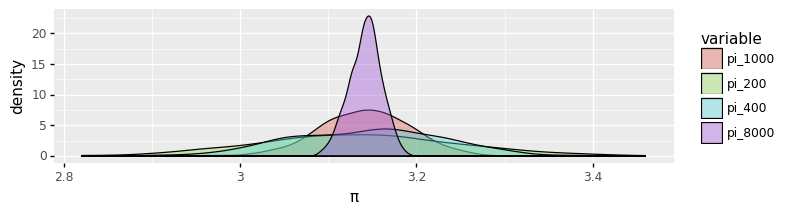

<ggplot: (314486001)>

In [ ]:
# np.random.choice(x, replace=True)
# compute π
S = int(1e6)

# we have an indicator variable for whether we are in the circle
# we are trying to approximate integration
# we sumulate the indicator variable Ind(x'x < 1) for all kind of x ~ Unif(0, 1)

def generate_pi(n):
    area_circle = ((np.random.rand(n, 2) ** 2).sum(axis=1) < 1).mean()
    return 4 * area_circle

x = [[generate_pi(m) for _ in range(400)] for m in [200, 400, 1000, 8000]]

df = pd.DataFrame(np.array(x).T, columns=["pi_200", "pi_400", "pi_1000", "pi_8000"])

(ggplot(df.melt()) +
    aes(x='value', fill='variable') +
    geom_density(alpha=0.4) +
    xlab("π")
)


In [ ]:
np.pi

3.141592653589793

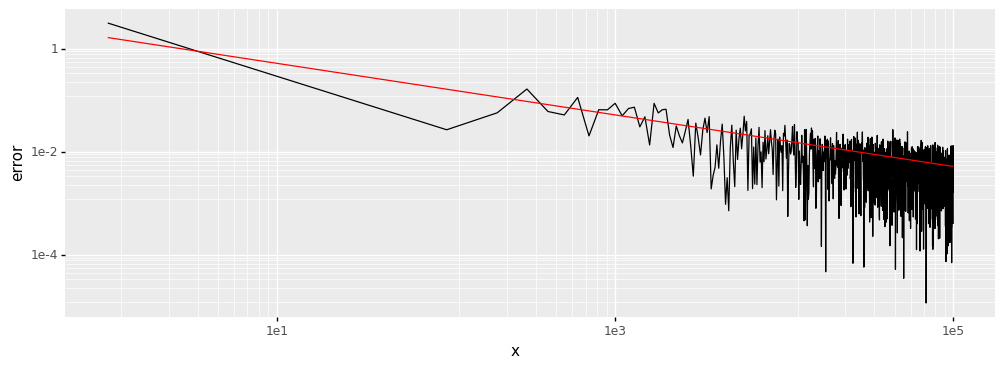

<ggplot: (315842021)>

In [ ]:
# Convergence
from plotnine import geom_line, scale_x_continuous, scale_x_log10, scale_y_log10, geom_abline

ggplot_options.figure_size = (12, 4)

r = np.arange(1, 10**5, 100)
sd_pi = np.sqrt((16 / r) * (np.pi / 4) * (1 - np.pi / 4))


(pd.DataFrame({
    'x': r,
    'std_pi_upper': sd_pi,
    # 'var_pi_bottom': -var_pi,
    # 'y': var_pi,
    'error': np.abs([generate_pi(m) - np.pi for m in r])
}).pipe(ggplot) +
    aes(x='x', y='error') +
    geom_line(aes()) +
    # roughly -0.5 slope of the sd line
    geom_line(aes(y='std_pi_upper'), color='red') +

    scale_x_log10() +
    scale_y_log10()
)

On a logarithmic scale, the variance line has a slope of -0.5. That means, that in order to decrease the error by one digit after the floating point, we need ten times more elements.

<b style="color: red" >For precision $10^{-7}$ we need $10^{14}$ samples.</b>

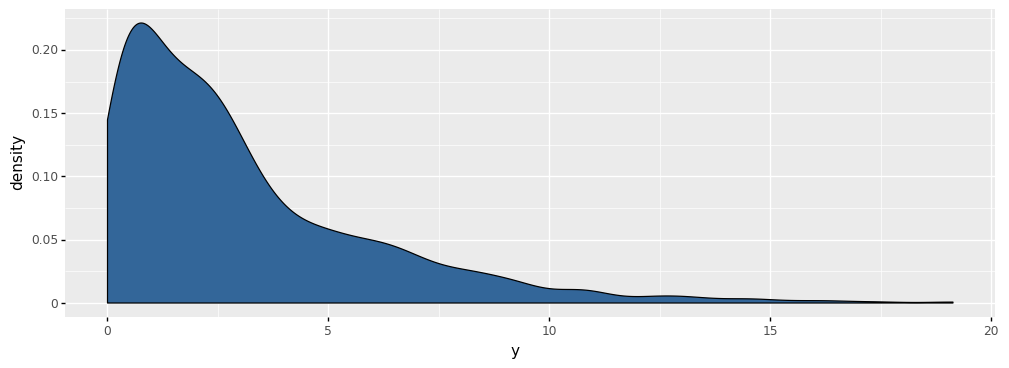

<ggplot: (315841796)>

In [ ]:
l = 3
y = - l * np.log(np.random.rand(1000))

# Inverse probability transform
ggplot(pd.DataFrame({'y': y})) + aes(x='y') + geom_density(fill="#336699")

### Importance Sampling

<AxesSubplot:>

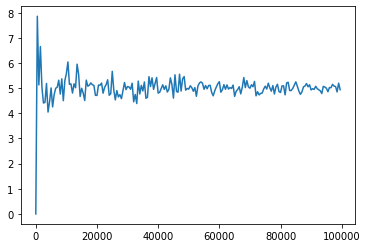

In [15]:
from scipy.stats import norm, expon
import seaborn as sns
# we want to get the mean of N(5, 1), using sampling from exponential

def generate_mean(size):
    x = np.random.exponential(1, size=size)
    return (x * (norm.pdf(x, 5, 1) / expon.pdf(x))).mean()

sns.lineplot(y=[generate_mean(n) for n in np.arange(1, int(1e5), 500)], x=np.arange(1, int(1e5), 500))

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

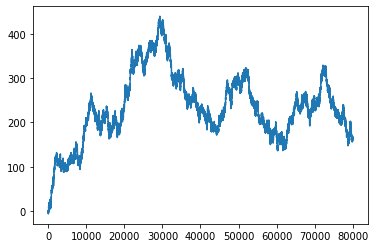

In [122]:
from itertools import accumulate

x = list(range(0, 80000))
y = [*accumulate(x, lambda a, _: np.random.normal(a))]

sns.lineplot(x, y)


In [143]:
from scipy.stats import norm
norm.rvs(5)

4.261182959244121

In [275]:
# we have a distribution
import plotly.express as px
from scipy.integrate import quad

def target_distribution(x):
    # the numerator that we care about
    density = np.exp(-x**2) * (2 + np.sin(x*5) + np.sin(x*2))
    # return density
    # if we want to have a normalized
    return density / 3.544829393038085


x = np.arange(-3,3, 0.01)
y = target_distribution(x)

px.line(x = x, y = y)

<AxesSubplot:ylabel='Density'>

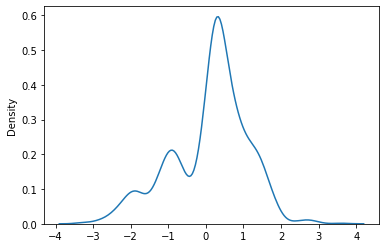

In [287]:
# we have a distribution
import plotly.express as px
from scipy.integrate import quad
# import time
from random import sample
import plotly.figure_factory as ff

def sample_metropolis_hastings(start, target_dist, proposal_dist, n_iter=int(1e5)):
    result = []
    previous_x = start

    for i in range(n_iter):
        proposal_x = proposal_dist.rvs(previous_x)
        ratio = (target_dist(proposal_x) / target_dist(previous_x)) * (proposal_dist.pdf(proposal_x) / proposal_dist.pdf(proposal_x))
        if ratio >= 1:
            result = result + [proposal_x]
            previous_x = proposal_x
        else:
            u = np.random.rand()
            if u < ratio:
                result = result + [proposal_x]
                previous_x = proposal_x
    
    np.random.shuffle(result[1000:])
    return result

def step(target_dist, step_dist, prev_x):
    step_x = step_dist.rvs(prev_x)
    ratio = (target_dist(step_x) / target_dist(prev_x)) * (step_dist.pdf(prev_x) / step_dist.pdf(step_x))
    return step_x if ratio >= 1 or np.random.rand() < ratio else prev_x

def sample_metropolis_hastings(start, target_dist, proposal_dist, n=int(1e5)):
    result = [*accumulate([start] + list(range(n)), lambda x, _: step(target_dist, proposal_dist, x))]
    return result[1000:]

x = sample_metropolis_hastings(0, target_distribution, norm, 5000)
sns.kdeplot(x)

In [288]:

def sample_metropolis_hastings(start, target_dist, step_dist, sd=1, n=int(1e4)):
    def step(prev_x, sd=sd):
        proposal_x = step_dist.rvs(prev_x, sd)
        target_ratio = target_dist(proposal_x) / target_dist(prev_x)
        proposal_ratio = step_dist.pdf(proposal_x) / step_dist.pdf(prev_x)
        ratio = target_ratio * proposal_ratio
        return proposal_x if ratio >= min(1, np.random.rand()) else prev_x

    return [*accumulate([start, *range(n)], lambda x, _: step(x))]

x = sample_metropolis_hastings(0, target_distribution, norm)

fig = ff.create_distplot([x], ['distplot'])
fig.show()

<AxesSubplot:ylabel='Density'>

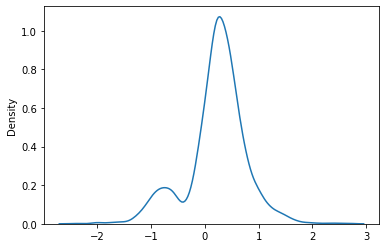

In [286]:
sns.kdeplot(x)

## **Gibbs Sampling**

In [343]:
def cond_sampler(i, x, mean, cov):
    mu = mean[i] + (cov[i, 1-i] / cov[1-i, 1-i]) * (x[1-i] - mean[1-i])
    sigma = np.sqrt(cov[i, i] - (cov[i, 1-i] ** 2) / cov[1-i, 1-i])
    # x0|x1 ~ N(µ0 + (∑01 / ∑11)(x1 - µ1) , ∑00 - ∑01^2/∑11)
    # x1|x0 ~ N(µ1 + (∑10 / ∑00)(x0 - µ0) , ∑11 - ∑10^2/∑00)
    return norm.rvs(mu, sigma)

def step(point, mean, cov):
    x0, x1 = point
    x0 = cond_sampler(0, np.array([x0, x1]), mean, cov)
    x1 = cond_sampler(1, np.array([x0, x1]), mean, cov)
    return np.array([x0, x1])

def gibbs_sampler(start_point, mean, cov):
    point = np.array([*start_point])

    while True:
        point = step(point, mean, cov)
        yield point

start = np.array([0, 0])
cov = np.array([[10, 3], [3, 5]])

generator = gibbs_sampler(start, np.array([1, 2]), cov)

for i in range(100000):
    x = next(generator)


/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

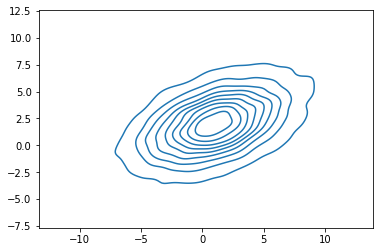

In [347]:
a = np.array([next(generator) for i in range(10000)])
sns.kdeplot(a[:,0], a[:, 1])

In [479]:
from hmc import hamiltonian_sample

n = 10000
mu, sigma, v = (2, 4, 2)

x = norm.rvs(mu, sigma, n)
y_cond_x = norm.rvs(x, v, n)

def posterior(x, y, n):
    #      prior                   likelihood
    return norm.pdf(x, mu, sigma) * norm.pdf(y[0:n], x, v).prod()

generator = hamiltonian_sample(2, lambda x: posterior(x, y_cond_x, 30), 1, 10)

In [480]:
[next(generator) for _ in range(5 * int(1e4))];

In [481]:
x_cond_y = [next(generator) for _ in range(int(1e4))]

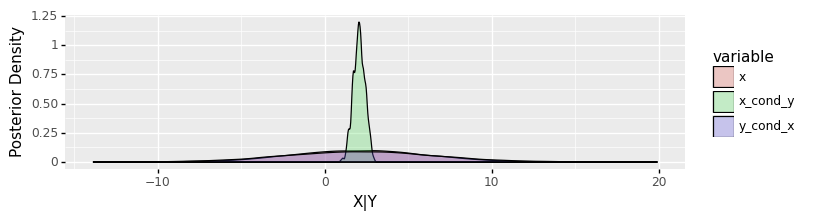

<ggplot: (336026170)>

In [482]:
from plotnine import ggplot, aes, geom_density, ggtitle, xlab, ylab
df = pd.DataFrame({'x_cond_y': x_cond_y, 'x': x, 'y_cond_x': y_cond_x})

(ggplot(df.melt()) + aes(x='value', fill='variable') + geom_density(alpha=0.3) + xlab("X|Y") + ylab("Posterior Density"))

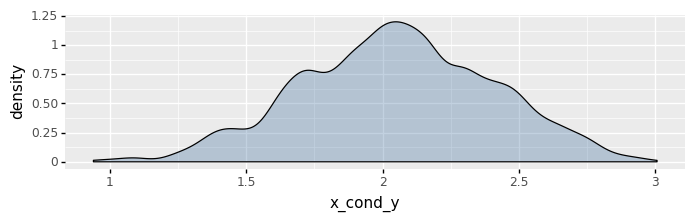

<ggplot: (335698008)>

In [483]:
(ggplot(df) + aes(x='x_cond_y') + geom_density(alpha=0.3, fill='#336699'))

In [487]:
np.array(x_cond_y).mean()

2.051943460975537

Първоначално, оценката е изместена докато се съберат достатъчно елементи. Това се вижда аналитично от постериорното разпределение.

## **Gaussian Distribution**

$$
\Sigma_{ij} = 0 \implies p(x_i, x_j) = \mathcal{N}(x_i, [\mu]_i, [\Sigma_{ii}]) \cdot \mathcal{N}(x_j, [\mu]_j, [\Sigma_{jj}])
$$




## **Linear Generative Model**

$$
f(x)=w_1 + w_2x = \phi_x'w\\
p(w) = \mathcal{N}(w; \mu, \Sigma)
$$

In [515]:
from scipy.stats import multivariate_normal

w = multivariate_normal.rvs(mean=[0, 0], cov=1, size=2000)
x = np.random.uniform(-8, 8, 2000)


f = w[:, 0] + w[:, 1] * x
f

array([  1.0980195 , -11.32235354,   1.95806206, ...,   2.15693301,
        -1.53606121,   1.91998806])

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

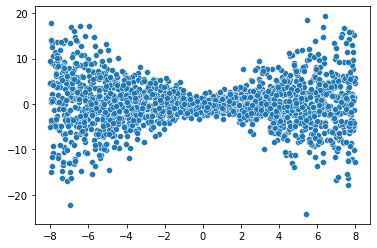

In [518]:
sns.scatterplot(x, f)
# The mean is at zero
# Can we plot one standard deviation from the mean 0 for every point of x?
# What would be 1 standard deviation from the mean 0 at point x=4. 

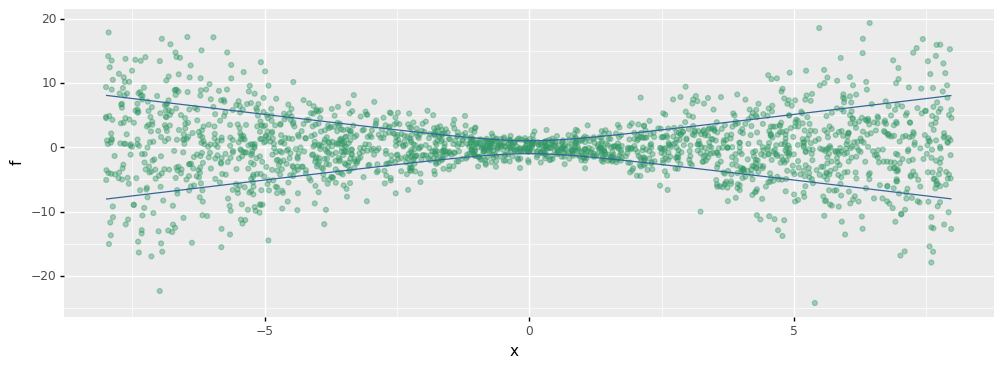

<ggplot: (334534647)>

In [538]:
ggplot_options.figure_size = (12, 4)

(pd.DataFrame({
    'x': x,
    'f': f,
    'mean+std': np.sqrt(1 + x**2),
    'mean-std': -np.sqrt(1 + x**2)
})
.pipe(ggplot) +
    aes(x='x', y='f') +
    geom_point(alpha=0.4, color="#339966") +
    geom_line(aes(x='x', y='mean+std'), color='#336699') +
    geom_line(aes(x='x', y='mean-std'), color='#336699')
)